# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [8]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
df = pd.read_sql_query(""" SELECT * FROM Reviews  """, con) 
df.to_pickle("Reviews")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
df.Score.value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [7]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


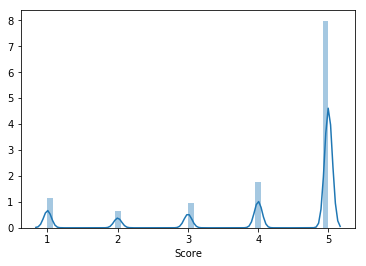

In [10]:
sns.distplot(df.Score)

** Score as positive or negative **

In [22]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    else:
        return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [23]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [20]:
filtered_data.Score.value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

In [8]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2.Using Text data and Natural Language Processing (NLP)

Firstly we need to perform some data cleaning and then text preprocessing and convert the texts as vectors so that we can train some model on those vectors and predict polarity of the review

#  Exploratory Data Analysis

## 2.1 Data Cleaning: 

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [24]:
filtered_data.duplicated(subset={"UserId","ProfileName","Time","Text"}).value_counts()

False    364173
True     161641
dtype: int64

There exist alot of duplicates wherein the different products is ** reviewed by same user at the same time **.

The product ID may be different but the product is similar with different variant

In [25]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [26]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

** (i) Data Deduplication  **

In [27]:
#Deduplication of entries
df_no_dup =sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first')
df_no_dup.shape

(364173, 10)

In [28]:
size_diff = df_no_dup['Id'].size/df['Id'].size
print("%.1f %% reduction in data after deleting duplicates"%((1-size_diff)*100))
print("Size of data",df_no_dup['Id'].size," rows ")

35.9 % reduction in data after deleting duplicates
Size of data 364173  rows 


** (ii) Helpfullness Numerator Greater than Helpfullness Denominator **

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [18]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [29]:
final=df_no_dup[df_no_dup.HelpfulnessNumerator<=df_no_dup.HelpfulnessDenominator]
print("Size of data",final['Id'].size," rows ")

Size of data 364171  rows 


In [30]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 2.2  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

** HTML Tag Removal  **

In [45]:
import re #Regex (Regualar Expr Operations)
#string = r"sdfsdfd" :- r is for raw string as Regex often uses \ backslashes(\w), so they are often raw strings(r’\d’)

########Function to remove html tags from data ##########################################
def cleanhtml(data):
    p = re.compile('<.*?>')#Find this kind of pattern
    #lenp = len(p.findall(data))
#     print(p.findall(data))#List of strings which follow the regex pattern
    return p.sub('',data) #Substitute nothing at the place of strings which matched the patterns


########Function to remove html tags from data ##########################################

cleanhtml('<a href="foo.com" class="bar">I Want This <b>text!</b></a><>')


'I Want This text!'

In [42]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    #print(sent)
    l,p  = cleanhtml(sent)
    if l > 0:
        print(i)
        print(p)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.First, this book taught him the months of the year.Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


** Remove Punctuations **

In [46]:
########Function to remove html tags from data ################################################

def cleanpunc(data):
    p = re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return p.sub('',data)

########Function to remove html tags from data ################################################
cleanpunc("fsd*?~,,,( sdfsdfdsvv)#")

'fsd sdfsdfdsvv'

** Stopwords **

Stop words usually refers to the most common words in a language are generally filtered out before or after processing of natural language data. Sometimes it is avoided to remove the stop words to support phrase search.

In [52]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('stopwords')


In [53]:
#stop = set(stopwords.words('english')) #set of stopwords
stop = stopwords.words('english') #set of stopwords
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',

** Stemming **

** Porter Stemmer **: Most commonly used stemmer without a doubt, also one of the most gentle stemmers. Though it is also the most computationally intensive of the algorithms. It is also the oldest stemming algorithm by a large margin.

**SnowBall Stemmer(Porter2) **: Nearly universally regarded as an improvement over porter, and for good reason. Porter himself in fact admits that it is better than his original algorithm. Slightly faster computation time than Porter, with a fairly large community around it.

In [55]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer
print("Stem/Root words of the some of the words using SnowBall Stemmer:")
print(snow.stem('tasty'))
print(snow.stem('tasteful'))
print(snow.stem('tastiest'))
print(snow.stem('delicious'))
print(snow.stem('amazing'))
print(snow.stem('amaze'))
print(snow.stem('initialize'))
print(snow.stem('fabulous'))
print(snow.stem('Honda City'))
print(snow.stem('unpleasant'))
print(snow.stem('bouyancy'))

Stem/Root words of the some of the words using SnowBall Stemmer:
tasti
tast
tastiest
delici
amaz
amaz
initi
fabul
honda c
unpleas
bouyanc


** Preprocessing output for one review **

In [73]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'][2:3].values: #Running only for 2nd review
    filtered_sentence=[]
    print(sent) #Each review
    sent=cleanhtml(sent)# remove HTMl tags
    sent=cleanpunc(sent)# remove Punctuation Symbols
    print(sent.split())
    for word in sent.split():
        print("================================>",word)
        if((word.isalpha()) and (len(word)>2)):#If it is a numerical value or character of lenght less than 2    
            if(word.lower() not in stop):# If it is a stopword
                s=(snow.stem(word.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
                print(final['Score'].values[i])
            else:
                print("Eliminated as it is a stopword")
                continue
        else:
            print("Eliminated as it is a numerical value or character of length less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    
    print("***********************************************************************")
    print("Finally selected words from the review:\n",final_string)

This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.
['This', 'is', 'a', 'fun', 'way', 'for', 'children', 'to', 'learn', 'their', 'months', 'of', 'the', 'year', 'We', 'will', 'learn', 'all', 'of', 'the', 'poems', 'throughout', 'the', 'school', 'year', 'they', 'like', 'the', 'handmotions', 'which', 'I', 'invent', 'for', 'each', 'poem']
================================> This
Eliminated as it is a stopword
================================> is
Eliminated as it is a numerical value or character of length less than 2
================================> a
Eliminated as it is a numerical value or character of length less than 2
================================> fun
Selected: Stem Word-> b'fun'
positive
================================> way
Selected: Stem Word-> b'way'
positive
================================> for
Eliminated as it is a stopword
=======================

In [70]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

** Preprocessing on all the reviews **

In [83]:
%%time
from time import time
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
# Code takes a while to run as it needs to run on around 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
t0=time()
for sent in final['Text'].values:
    filtered_sentence=[]
#     print(sent) #Each review
    sent=cleanhtml(sent)# remove HTMl tags
    sent=cleanpunc(sent)# remove Punctuation Symbols
#     print(sent.split())
    for word in sent.split():
#         print("================================>",w)
        if((word.isalpha()) and (len(word)>2)):#If it is a numerical value or character of lenght less than 2    
            if(word.lower() not in stop):# If it is a stopword
                s=(snow.stem(word.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                                        #encoding as byte-string/utf-8
#                 print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
                print
                if (final['Score'].values)[i] == 'positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
#                 print("Eliminated as it is a stopword")
                continue
        else:
#             print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
            #encoding as byte-string/utf-8
    
    final_string.append(str1)
#     print("***********************************************************************")
#     print("Finally selected words from the review:\n",final_string)
    i+=1
print("Preprocessing completed in ")

Preprocessing completed in 
Wall time: 11min


In [84]:
len(final_string)

364171

** Postive and Negative words in reviews **

In [96]:
from collections import Counter
print("No. of positive words:",len(all_positive_words))
print("No. of negative words:",len(all_negative_words))
# print("Sample postive words",all_positive_words[:9])
# print("Sample negative words",all_negative_words[:9])
positive = Counter(all_positive_words)
print("\nMost Common postive words",positive.most_common(15))
negative = Counter(all_negative_words)
print("\nMost Common negative words",negative.most_common(15))

No. of positive words: 11678143
No. of negative words: 2393755

Most Common postive words [(b'not', 145018), (b'like', 138338), (b'tast', 126026), (b'good', 109838), (b'love', 106551), (b'flavor', 106404), (b'use', 102874), (b'great', 101124), (b'one', 94399), (b'product', 88466), (b'tri', 85105), (b'tea', 81831), (b'coffe', 76659), (b'make', 74451), (b'get', 71691)]

Most Common negative words [(b'not', 53635), (b'tast', 33826), (b'like', 32056), (b'product', 27411), (b'one', 20173), (b'flavor', 18902), (b'would', 17856), (b'tri', 17514), (b'use', 15146), (b'good', 14616), (b'coffe', 14290), (b'get', 13706), (b'buy', 13607), (b'order', 12700), (b'food', 12376)]


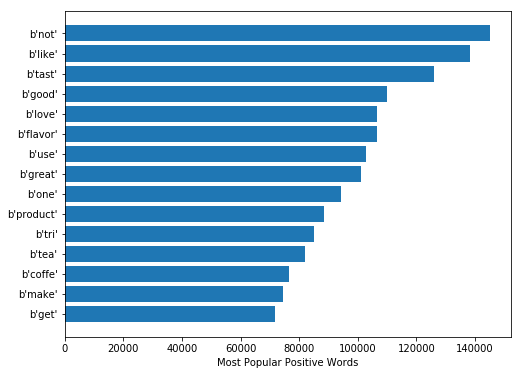

In [97]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6))
pos_words = positive.most_common(15)
pos_words.sort(key=lambda x: x[1], reverse=False) 
words=[]
times=[]
for w,t in pos_words:
    words.append(w)
    times.append(t)
plt.barh(range(len(words)),times)
plt.yticks(range(len(words)),words) 
plt.xlabel('Most Popular Positive Words')
plt.show()

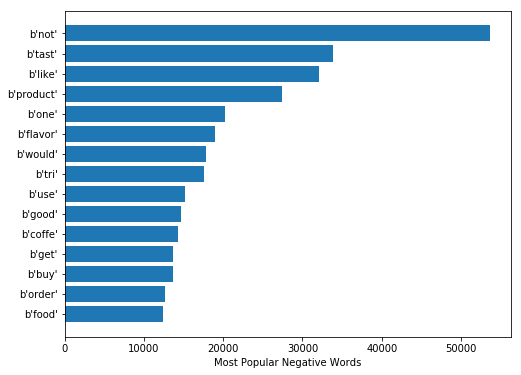

In [100]:
neg_words = negative.most_common(15)
neg_words.sort(key=lambda x: x[1], reverse=False) 
figure(num=None, figsize=(8, 6))
#print(neg_words)
words=[]
times=[]
for w,t in neg_words:
    words.append(w)
    times.append(t)
plt.barh(range(len(words)),times)
plt.yticks(range(len(words)),words) 
plt.xlabel('Most Popular Negative Words')
plt.show()

* "tast" , "like" , "flavor", "good" and "one" are some of the most common words in both negative and positve reviews
* "good" and "great" are some of the most common words in positive reviews
* "would" and "coffe" are some of the most common words in negative reviews 
* tasty, good, etc are some of the words common in both <b>because there may be a not before it like "not tasty" , "not good"</b>

** Cleaned text Without Stemming for Google trained W2Vec **

In [112]:
%%time
# Code takes a while to run as it needs to run on around 500k sentences.
i=0
str1=' '
final_string_nostem=[]
s=''
t0=time()
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)# remove HTMl tags
    sent=cleanpunc(sent)# remove Punctuation Symbols
    for word in sent.split():
        if((word.isalpha()) and (len(word)>2)):#If it is a numerical value or character of lenght less than 2    
            if(word.lower() not in stop):# If it is a stopword
                s=word.lower().encode('utf8') #encoding as byte-string/utf-8
                filtered_sentence.append(s)
            else:
                continue
        else:
            continue 
    str1 = b" ".join(filtered_sentence)     
    final_string_nostem.append(str1)
    i+=1
print("Preprocessing completed in ")

Preprocessing completed in 
Wall time: 1min 43s


In [113]:
len(final_string_nostem)

364171

** Store the final cleaned text in Sqllite DB **

In [116]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

final['CleanedText_NoStem']=final_string_nostem
final['CleanedText_NoStem'] = final['CleanedText_NoStem'].str.decode("utf-8")


In [117]:
final[['CleanedText','CleanedText_NoStem']].head(3) #below the processed review can be seen in the CleanedText Column 

,CleanedText,CleanedText_NoStem
138706,witti littl book make son laugh loud recit car...,witty little book makes son laugh loud recite ...
138688,grew read sendak book watch realli rosi movi i...,grew reading sendak books watching really rosi...
138689,fun way children learn month year learn poem t...,fun way children learn months year learn poems...


In [118]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

** Retrieve the data stored  pertaining to the cleaned text to verify **

In [120]:
# using the SQLite Table to read data.
con = sqlite3.connect('final.sqlite') 
#retrieving first 3 rows to check the data stored in Review table in database Final
df_new = pd.read_sql_query(""" SELECT * FROM Reviews limit 3""", con) 

In [121]:
df_new

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,witty little book makes son laugh loud recite ...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...,grew reading sendak books watching really rosi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...,fun way children learn months year learn poems...


# Some Key NATURAL LANGUAGE PROCESSING(NLP) Terms:

## Natural Language Processing (NLP) 
A Computer Science field connected to Artificial Intelligence and Computational Linguistics which focuses on interactions between computers and human language and a machine’s ability to understand, or mimic the understanding of human language. Examples of NLP applications include Siri and Google Now.

## Information Extraction 
The process of automatically extracting structured information from unstructured and/or semi-structured sources, such as text documents or web pages for example.

## Sentiment Analysis 
The use of Natural Language Processing techniques to extract subjective information from a piece of text. i.e. whether an author is being subjective or objective or even positive or negative. (can also be referred to as Opinion Mining). As in this case we doing sentiment analysis of reviews of users from Amazon.

## Data Corpus or Corpora 
A usually large collection of documents that can be used to infer and validate linguistic rules, as well as to do statistical analysis and hypothesis testing.eg. The Amazon Fine Food Review dataset is a corpus.

## Document
A "document" is a distinct text, you could treat an individual paragraph or even sentence as a "document".<br>
In our case our each review is a document


# 2.3 Bag of Words (BoW)

The ** bag-of-words model ** is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

The bag-of-words model is commonly used in methods of document classification where the (frequency of) occurrence of each word is used as a feature for training a classifier.

<img src="Bow2.jpg">

** Ways to convert text to vector **

2.3.1. Uni-gram BOW

In [123]:
%%time
uni_gram = CountVectorizer() #in scikit-learn from sklearn.feature_extraction.text import CountVectorizer
uni_gram_vectors = uni_gram.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(uni_gram_vectors))
print("the shape of out text BOW vectorizer ",uni_gram_vectors.get_shape())
print("the number of unique words ", uni_gram_vectors.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 209129)
the number of unique words  209129
Wall time: 23.1 s


In [125]:
#Saving the variable to access later without recomputing
pickle.dump(uni_gram_vectors,open("uni_gram"+".p","wb"), protocol=4)

In [126]:
df_temp = pickle.load(open("uni_gram"+".p","rb"))

In [128]:
df_temp

<364171x209129 sparse matrix of type '<class 'numpy.int64'>'
	with 11607905 stored elements in Compressed Sparse Row format>

** truncated singular value decomposition (SVD) **

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.

In [ ]:
%%time
from sklearn.decomposition import TruncatedSVD

tsvd_uni = TruncatedSVD(n_components=1000)#No of components as total dimensions
tsvd_uni_vec = tsvd_uni.fit_transform(uni_gram_vectors)

## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [44]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 2923725)
the number of unique words including both unigrams and bigrams  2923725


# [7.2.5] TF-IDF

In [33]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 2923725)
the number of unique words including both unigrams and bigrams  2923725


In [32]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100000:100010])

some sample features(unique words in the corpus) ['antler fair', 'antler fall', 'antler fantast', 'antler far', 'antler fault', 'antler favorit', 'antler feel', 'antler french', 'antler get', 'antler girl']


In [34]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [35]:
top_tfidf

,feature,tfidf
0,page open,0.192673
1,read sendak,0.192673
2,movi incorpor,0.192673
3,paperback seem,0.192673
4,version paperback,0.192673
5,flimsi take,0.192673
6,incorpor love,0.192673
7,rosi movi,0.192673
8,keep page,0.192673
9,grew read,0.192673


# [7.2.6] Word2Vec

In [39]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell


model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print("the vector representation of word 'computer'",model.wv['computer'])
print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

the vector representation of word 'computer' [ 1.07421875e-01 -2.01171875e-01  1.23046875e-01  2.11914062e-01
 -9.13085938e-02  2.16796875e-01 -1.31835938e-01  8.30078125e-02
  2.02148438e-01  4.78515625e-02  3.66210938e-02 -2.45361328e-02
  2.39257812e-02 -1.60156250e-01 -2.61230469e-02  9.71679688e-02
 -6.34765625e-02  1.84570312e-01  1.70898438e-01 -1.63085938e-01
 -1.09375000e-01  1.49414062e-01 -4.65393066e-04  9.61914062e-02
  1.68945312e-01  2.60925293e-03  8.93554688e-02  6.49414062e-02
  3.56445312e-02 -6.93359375e-02 -1.46484375e-01 -1.21093750e-01
 -2.27539062e-01  2.45361328e-02 -1.24511719e-01 -3.18359375e-01
 -2.20703125e-01  1.30859375e-01  3.66210938e-02 -3.63769531e-02
 -1.13281250e-01  1.95312500e-01  9.76562500e-02  1.26953125e-01
  6.59179688e-02  6.93359375e-02  1.02539062e-02  1.75781250e-01
 -1.68945312e-01  1.21307373e-03 -2.98828125e-01 -1.15234375e-01
  5.66406250e-02 -1.77734375e-01 -2.08984375e-01  1.76757812e-01
  2.38037109e-02 -2.57812500e-01 -4.46777344e

KeyError: "word 'tasti' not in vocabulary"

In [50]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [51]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [53]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [63]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  21938
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two']


In [56]:
w2v_model.wv.most_similar('tasti')

[('delici', 0.811565637588501),
 ('tastey', 0.7988753318786621),
 ('yummi', 0.770585834980011),
 ('satisfi', 0.6894760131835938),
 ('good', 0.6716829538345337),
 ('nice', 0.6640280485153198),
 ('hearti', 0.6638340950012207),
 ('nutriti', 0.661227822303772),
 ('crunchi', 0.656670331954956),
 ('versatil', 0.6266734004020691)]

In [57]:
w2v_model.wv.most_similar('like')

[('weird', 0.7463775277137756),
 ('dislik', 0.7033219933509827),
 ('okay', 0.6805294752120972),
 ('prefer', 0.671764612197876),
 ('gross', 0.670783519744873),
 ('appeal', 0.6521075963973999),
 ('resembl', 0.641674280166626),
 ('funki', 0.6357078552246094),
 ('yucki', 0.6338918209075928),
 ('hate', 0.6323825716972351)]

In [59]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
print(count_vect_feat[count_vect_feat.index('like')])

like


# [7.2.7] Avg W2V, TFIDF-W2V

In [64]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

364171
50


In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1